In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def arrayToColors(data):

    data=(data-np.min(data))/(np.max(data)-np.min(data))
    return mpl.cm.plasma(np.array(data))

def getData():
    data=[]
    
    files=glob.glob("data/*")
    badFiles=[]

    for name in files:
        pointiness,temp=name.split("spacing")
        spacing,length=temp.split("length")
        pointiness=float(pointiness[15:-1])
        spacing=float(spacing[:-1])
        length=float(length[:-4])

        try:
            thisData=loadFile(name+"/table.txt")
            thisData.attrs["pointiness"]=pointiness
        
            thisData.attrs["spacing"]=spacing
            thisData.attrs["length"]=length
            data.append(thisData)
        except Exception as e:
            badFiles.append(name)
            continue


    print(f"Could not load {len(badFiles)}/{len(files)} file")
    return data

def getClosestPlot(spacing,pointiness,length):
    minDist=None
    bestRun=None
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)+abs(run.attrs["pointiness"]-pointiness)+abs(run.attrs["length"]-length)
        if minDist is None or dist<minDist:
            minDist=dist
            bestRun=run
    return bestRun


def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if i.attrs["pointiness"] not in pointinessVals: pointinessVals.append(i.attrs["pointiness"])
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals



data=getData()
pointinessVals, spacingVals, lengthVals = getPossibleVals(data)


data4d=pd.read_csv("4d.csv")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Could not load 0/143 file


/var/folders/rl/cpjcq0556r36l75xt982r2kh0000gn/T/ipykernel_29439/3483994320.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))


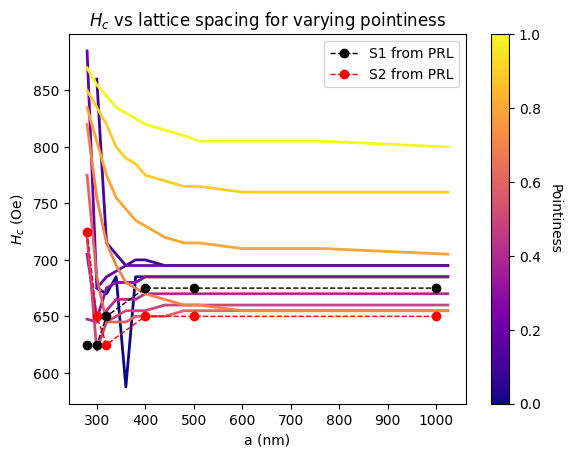

In [26]:

colors=plt.cm.plasma(pointinessVals)
for i,pointiness in enumerate(pointinessVals):
    Hc=[]
    spacings=[]
    for spacing in spacingVals:
        thisRun=getClosestPlot(spacing,pointiness,220e-9)
        Hc.append(thisRun.attrs["Hc"])
        spacings.append(spacing*1e9)
    plt.plot(spacings,Hc,"-",color=colors[i],linewidth=2)
    
cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Pointiness', rotation=270)
plt.title("$H_c$ vs lattice spacing for varying pointiness")
plt.xlabel("a (nm)")
plt.ylabel("$H_c$ (Oe)")


plt.plot(data4d["a"],data4d["Hc_S1"],"ko--",label="S1 from PRL",linewidth=1)
plt.plot(data4d["a"],data4d["Hc_S2"],"ro--",label="S2 from PRL",linewidth=1)
plt.legend()
    

Text(0.5, 1.0, '$H_c$ vs. Pointiness at 1024nm spacing')

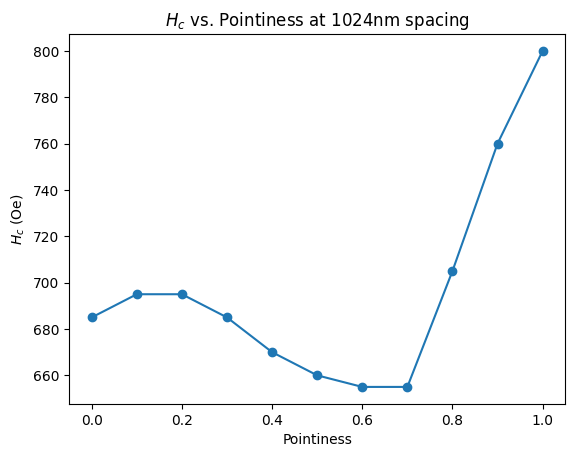

In [31]:
Hcs=[]
for pointiness in pointinessVals:
    run=getClosestPlot(1024e-9,pointiness,220e-9)
    Hcs.append(run.attrs["Hc"])
plt.plot(pointinessVals,Hcs,"o-")
plt.xlabel("Pointiness")
plt.ylabel("$H_c$ (Oe)")
plt.title("$H_c$ vs. Pointiness at 1024nm spacing")

/var/folders/rl/cpjcq0556r36l75xt982r2kh0000gn/T/ipykernel_29439/658295874.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))


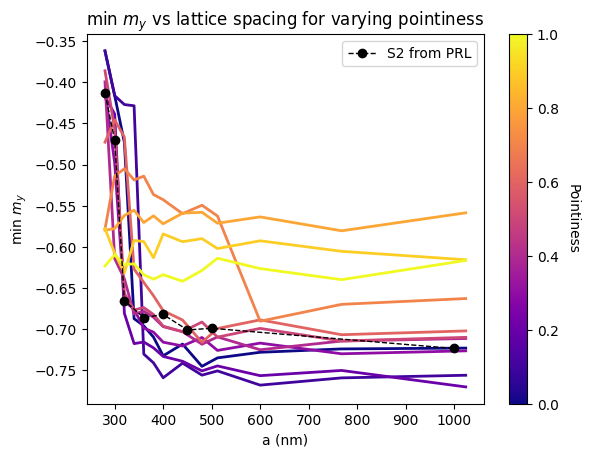

In [32]:
data4c=pd.read_csv("4c.csv")

colors=plt.cm.plasma(pointinessVals)
for i,pointiness in enumerate(pointinessVals):
    Hc=[]
    spacings=[]
    for spacing in spacingVals:
        thisRun=getClosestPlot(spacing,pointiness,220e-9)
        Hc.append(np.min(thisRun["hIsland_my"]))
        spacings.append(spacing*1e9)
    plt.plot(spacings,Hc,"-",color=colors[i],linewidth=2)
    
cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Pointiness', rotation=270)
plt.title("min $m_y$ vs lattice spacing for varying pointiness")
plt.xlabel("a (nm)")
plt.ylabel("min $m_y$")


plt.plot(data4c["a"],data4c["my-min"],"ko--",label="S2 from PRL",linewidth=1)
plt.legend()




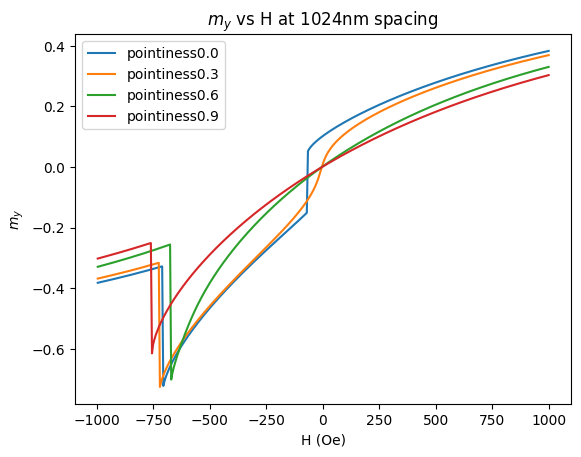

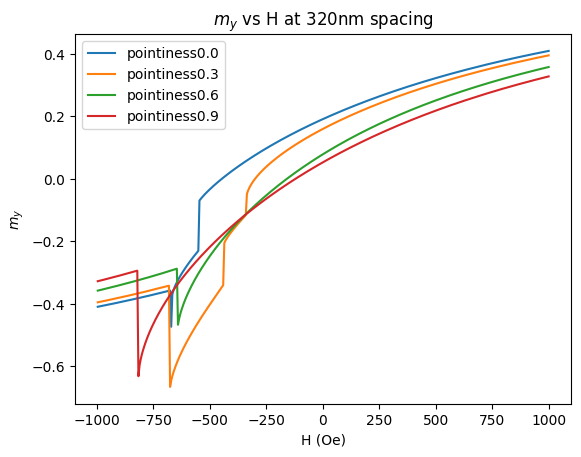

In [62]:
for pointiness in pointinessVals[::3]:
    minMy=[]
    spacings=[]

    thisRun=getClosestPlot(1024e-9,pointiness,220e-9)
    halfLength=int(len(thisRun["H"])/2)
    plt.plot(thisRun["H"][0:halfLength],thisRun["hIsland_my"][0:halfLength],label=f"pointiness{round(pointiness,1)}")

plt.xlabel("H (Oe)")
plt.ylabel("$m_y$")
plt.title("$m_y$ vs H at 1024nm spacing")
plt.legend()
plt.show()

for pointiness in pointinessVals[::3]:
    minMy=[]
    spacings=[]

    thisRun=getClosestPlot(320e-9,pointiness,220e-9)
    halfLength=int(len(thisRun["H"])/2)
    plt.plot(thisRun["H"][0:halfLength],thisRun["hIsland_my"][0:halfLength],label=f"pointiness{round(pointiness,1)}")

plt.xlabel("H (Oe)")
plt.ylabel("$m_y$")
plt.title("$m_y$ vs H at 320nm spacing")
plt.legend()
plt.show()


    

/var/folders/rl/cpjcq0556r36l75xt982r2kh0000gn/T/ipykernel_29439/2195594956.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


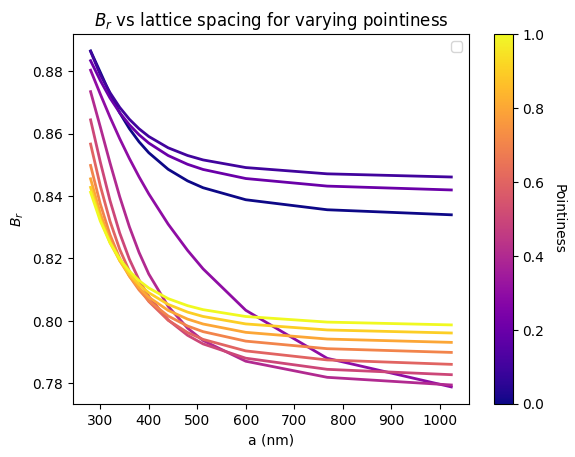

In [41]:

colors=plt.cm.plasma(pointinessVals)
for i,pointiness in enumerate(pointinessVals):
    Hc=[]
    spacings=[]
    for spacing in spacingVals:
        thisRun=getClosestPlot(spacing,pointiness,220e-9)
        Hc.append(thisRun.attrs["Br"])
        spacings.append(spacing*1e9)


    plt.plot(spacings,Hc,"-",color=colors[i],linewidth=2)
    
cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Pointiness', rotation=270)
plt.title("$B_r$ vs lattice spacing for varying pointiness")
plt.xlabel("a (nm)")
plt.ylabel("$B_r$")


plt.legend()
    

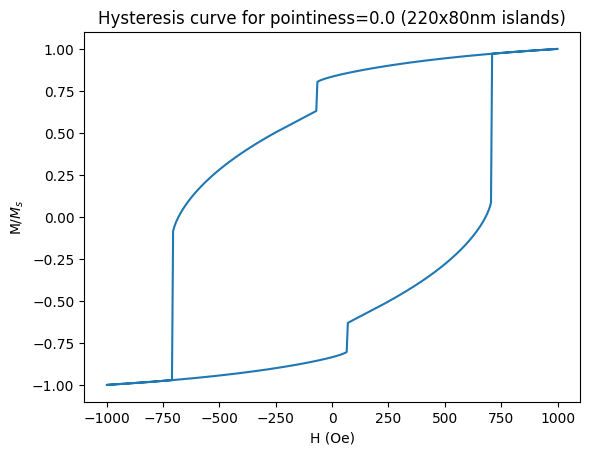

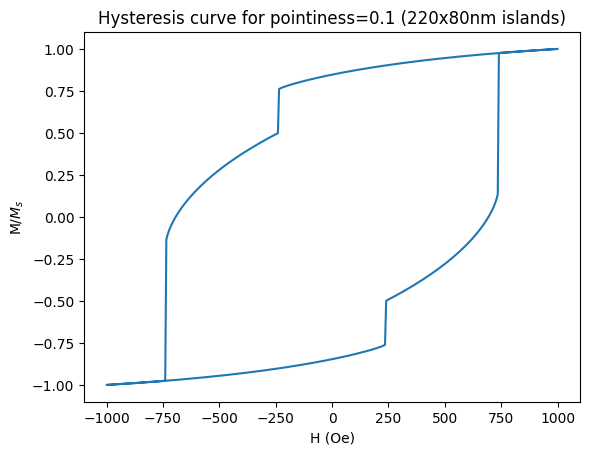

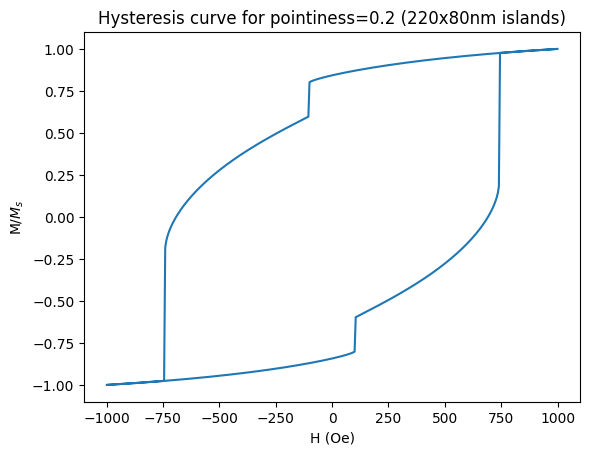

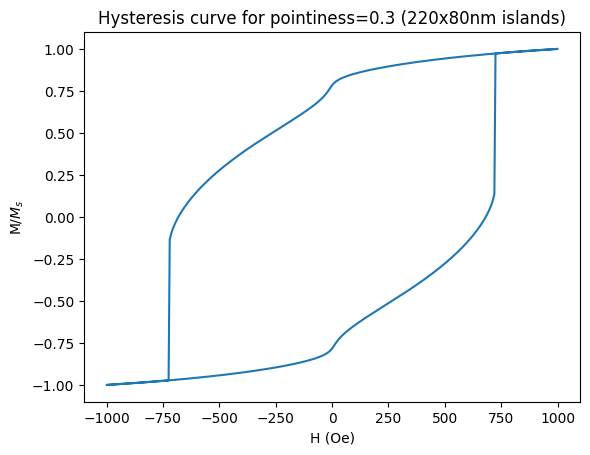

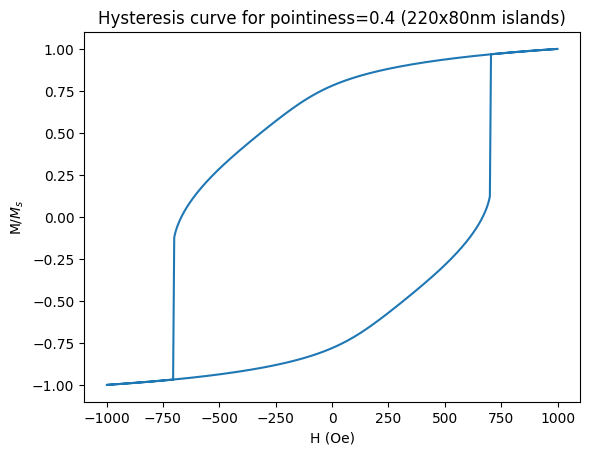

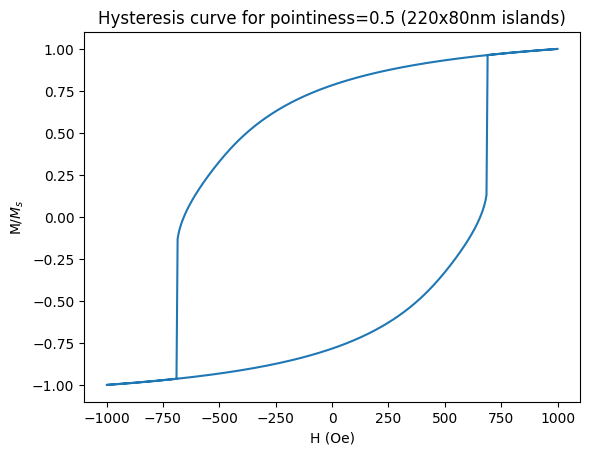

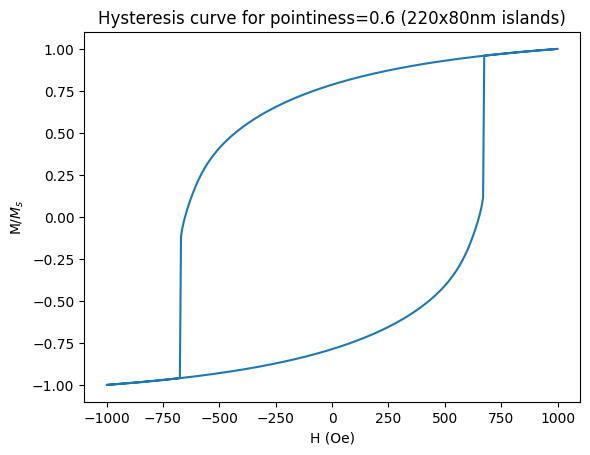

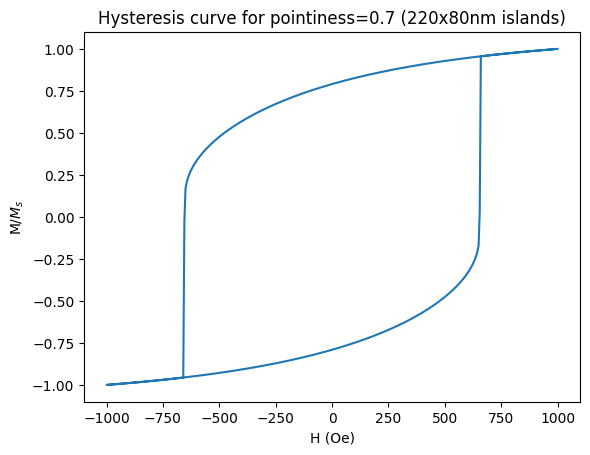

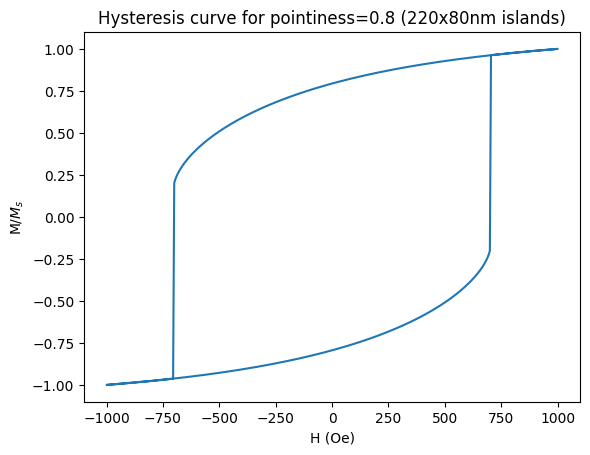

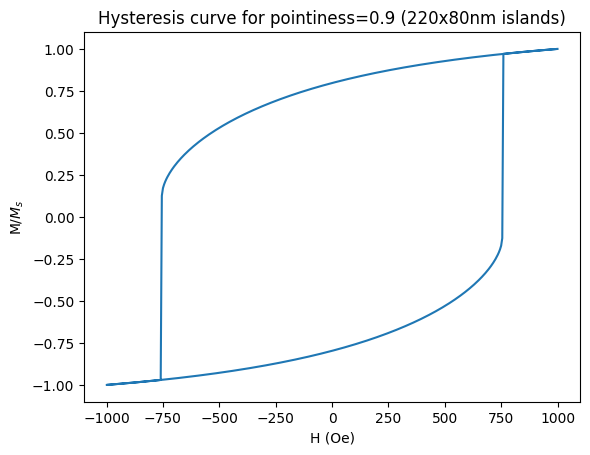

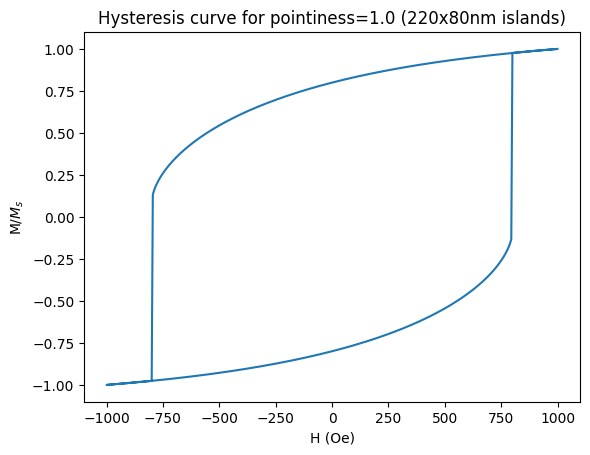

In [46]:
for i,pointiness in enumerate(pointinessVals):
    Hc=[]
    spacings=[]
    for spacing in spacingVals:
        thisRun=getClosestPlot(spacing,pointiness,220e-9)
        Hc.append(thisRun.attrs["Br"])
        spacings.append(spacing*1e9)

    
    plt.plot(thisRun["H"],thisRun["m"])
    plt.xlabel("H (Oe)")
    plt.ylabel("M/$M_s$")
    plt.title(f"Hysteresis curve for pointiness={round(pointiness,1)} (220x80nm islands)")
    plt.show()